# 04.10.2024

In [1]:
import matplotlib.pyplot as plt
import scipy.stats as sps
import scipy.special as special
import scipy.integrate as integrate
from statsmodels.stats.proportion import proportion_confint
import numpy as np
import math
from tqdm import tqdm

import os, sys
practice_dir = os.path.join(os.path.dirname(os.path.abspath('')), 'practice')
if not practice_dir in sys.path:
    sys.path.append(practice_dir)
from utils import generate_n_random_numbers

Экспериментально проверим достаточность размера выборки, необходимого для получения оценки математического ожидания (в случае неизвестной дисперсии)

In [2]:
P = 0.95
ANALYTICAL_EXPECTATION = 0
DISTROS = ["Uniform[-1, 1]", "Norm(0, 1)", "2xUniform[-1, 1]"]

[20, 58, 170, 500]


In [4]:
from functools import lru_cache

@lru_cache
def norm_quantile(p: float, loc=0, scale=1) -> float:
    return float(sps.norm.ppf(p, loc=loc, scale=scale))

@lru_cache
def student_quantile(p: float, n: int) -> float:
    return float(sps.t.ppf(p, n))

@lru_cache
def chi_squared_quantile(p: float, n: int) -> float:
    return sps.chi2.ppf(p, n)

In [27]:
def sigma_squared_estimate(sample: list) -> float:
    x_mean = np.mean(sample)
    return sum([pow(xi - x_mean, 2) for xi in sample]) / (len(sample) - 1)

def expectation_confidence_interval_2(sample: list, confidence_probability=P) -> tuple:
    n = len(sample)
    x_mean = np.mean(sample)
    term = student_quantile((1 + confidence_probability) / 2, n - 1) * math.sqrt(sigma_squared_estimate(sample) / n) 
    return (x_mean - term, x_mean + term)

def sigma_squared_confidence_interval(sample: list, confidence_probability=P) -> tuple:
    deviation_estimate = sigma_squared_estimate(sample)
    n = len(sample)
    return (deviation_estimate * (n - 1) / chi_squared_quantile((1 + confidence_probability) / 2, n - 1), 
            deviation_estimate * (n - 1) / chi_squared_quantile((1 - confidence_probability) / 2, n - 1))

Функция нахождения минимального достаточного размера выборки при неизвестной дисперсии

In [37]:
def calculate_sufficient_sample_size_no_sigma(distribution, delta: float, iterations=1, confidence_probability=P) -> int:
    def n_estimate_iteration(n_initial: int, last_iteration: True):
        min_sample = generate_n_random_numbers(n_initial, distribution)
        deviation_min, deviation_max = sigma_squared_confidence_interval(min_sample)
        # print(deviation_min, deviation_max)
        return int(math.ceil((deviation_max if last_iteration else deviation_min) * pow(student_quantile((1 + confidence_probability) / 2, n_initial - 1) / delta, 2)))

    n_min = 5
    for it in range(iterations):
        n_min = n_estimate_iteration(n_min, last_iteration=(it == iterations - 1))
    return n_min

In [54]:
methods = ['non-iterative', 'iterative']
method_to_iterations = {'non-iterative': 1, 'iterative': 3}
DELTAS = list(np.logspace(-1, -3, base=10, num = 3))
ITERATIONS = 10 ** 3
DELTAS

[np.float64(0.1), np.float64(0.01), np.float64(0.001)]

In [55]:
results = {d: {g: [] for g in ['intervals', 'points']} for d in DISTROS}
for d_id, d in enumerate(DISTROS):
    for delta_id, delta in enumerate(DELTAS):
        for method in methods:
            n = calculate_sufficient_sample_size_no_sigma(d, delta, iterations=method_to_iterations[method])
            print(f"Sufficient n for {d} and delta {delta} found by {method} method is {n}")
            if method != 'iterative':
                continue
            hits_counter = 0
            for _ in tqdm(range(ITERATIONS)):
                a, b = expectation_confidence_interval_2(sample=generate_n_random_numbers(n, d))
                hits_counter += a <= ANALYTICAL_EXPECTATION <= b
            results[d]["intervals"].append(proportion_confint(hits_counter, ITERATIONS, alpha=1 - P, method='normal'))
            results[d]["points"].append(hits_counter / ITERATIONS)

Sufficient n for Uniform[-1, 1] and delta 0.1 found by non-iterative method is 598
Sufficient n for Uniform[-1, 1] and delta 0.1 found by iterative method is 185


100%|██████████| 1000/1000 [00:00<00:00, 7840.83it/s]


Sufficient n for Uniform[-1, 1] and delta 0.01 found by non-iterative method is 281979
Sufficient n for Uniform[-1, 1] and delta 0.01 found by iterative method is 13142


100%|██████████| 1000/1000 [00:07<00:00, 126.34it/s]


Sufficient n for Uniform[-1, 1] and delta 0.001 found by non-iterative method is 14822470
Sufficient n for Uniform[-1, 1] and delta 0.001 found by iterative method is 1283574


100%|██████████| 1000/1000 [13:09<00:00,  1.27it/s]


Sufficient n for Norm(0, 1) and delta 0.1 found by non-iterative method is 7545
Sufficient n for Norm(0, 1) and delta 0.1 found by iterative method is 396


100%|██████████| 1000/1000 [00:00<00:00, 2536.56it/s]


Sufficient n for Norm(0, 1) and delta 0.01 found by non-iterative method is 409584
Sufficient n for Norm(0, 1) and delta 0.01 found by iterative method is 39258


100%|██████████| 1000/1000 [00:36<00:00, 27.09it/s]


Sufficient n for Norm(0, 1) and delta 0.001 found by non-iterative method is 39876655
Sufficient n for Norm(0, 1) and delta 0.001 found by iterative method is 3850336


100%|██████████| 1000/1000 [1:00:31<00:00,  3.63s/it]


Sufficient n for 2xUniform[-1, 1] and delta 0.1 found by non-iterative method is 4304
Sufficient n for 2xUniform[-1, 1] and delta 0.1 found by iterative method is 380


100%|██████████| 1000/1000 [00:00<00:00, 2550.36it/s]


Sufficient n for 2xUniform[-1, 1] and delta 0.01 found by non-iterative method is 36948
Sufficient n for 2xUniform[-1, 1] and delta 0.01 found by iterative method is 26244


100%|██████████| 1000/1000 [00:25<00:00, 38.76it/s]


Sufficient n for 2xUniform[-1, 1] and delta 0.001 found by non-iterative method is 40299148
Sufficient n for 2xUniform[-1, 1] and delta 0.001 found by iterative method is 2568766


100%|██████████| 1000/1000 [42:18<00:00,  2.54s/it]


In [56]:
results

{'Uniform[-1, 1]': {'intervals': [(0.9467100724424075, 0.9712899275575925),
   (0.9455675852261337, 0.9704324147738662),
   (0.9342388752630848, 0.9617611247369151)],
  'points': [np.float64(0.959), np.float64(0.958), np.float64(0.948)]},
 'Norm(0, 1)': {'intervals': [(0.9297495656523327, 0.9582504343476672),
   (0.9364918804423794, 0.9635081195576205),
   (0.9398827296270256, 0.9661172703729743)],
  'points': [np.float64(0.944), np.float64(0.95), np.float64(0.953)]},
 '2xUniform[-1, 1]': {'intervals': [(0.9342388752630848, 0.9617611247369151),
   (0.9376206076526052, 0.9643793923473947),
   (0.9331145162248677, 0.9608854837751322)],
  'points': [np.float64(0.948), np.float64(0.951), np.float64(0.947)]}}

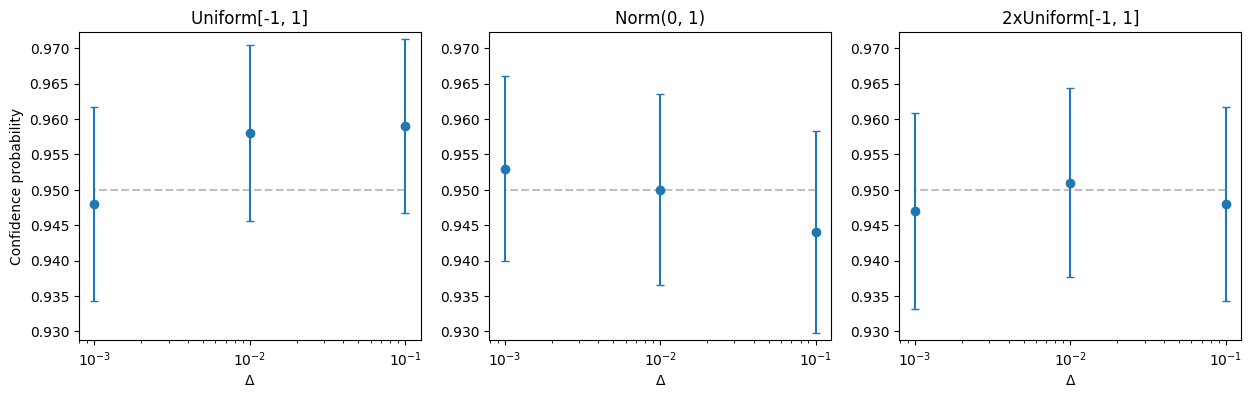

In [57]:
_, axis = plt.subplots(1, len(DISTROS), figsize=(5 * len(DISTROS), 4))
max_y, min_y = -np.inf, np.inf
y_error_min = []
for i, d in enumerate(DISTROS):
    y_error = list(map(lambda arr: np.abs(np.subtract(arr, results[d]['points'])), zip(*results[d]["intervals"])))
    axis[i].errorbar(DELTAS, results[d]["points"], yerr=y_error, fmt='o', capsize=3)
    axis[i].plot(DELTAS, [P] * len(DELTAS), color='gray', alpha=.5, linestyle='--')   
    min_y = min(min_y, np.min(np.subtract(results[d]['points'], y_error[0])))
    max_y = max(max_y, np.max(np.add(results[d]['points'], y_error[1])))

axis[0].set_ylabel("Confidence probability")
for i, d in enumerate(DISTROS):
    axis[i].set_xscale('log')
    axis[i].set_xlabel('Δ')
    axis[i].title.set_text(f"{d}")
    axis[i].set_ylim([min(min_y, P) - 0.001, max_y + 0.001])

Вычисление проводилось только для размера сэмплов, полученных итерационным способом, поскольку после одной итерации $n$ было слишком велико.